
## 🕵️ Credit Card Fraud Detection — EDA & Data Cleaning

**Purpose:** In this notebook, we will:
 - Explore the `creditcard.csv` dataset and its structure
 - Perform data cleaning and data transformations as needed
 - Conduct exploratory data analysis (EDA) by producing diagnostic plots and observations
 - Prepare features for modeling
 - Save a cleaned dataset for modeling.

**Notes / references**
- Dataset: Kaggle "Credit Card Fraud Detection" (anonymized PCA features V1..V28; only `Time` & `Amount` are original). Typical summary: 284,807 transactions, 492 frauds (~0.172% fraud).


## Step 1: Import Libraries and settings
- Import all nessasary libraries & settings

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os as os

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set seaborn styles
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

## Step 2: Load Dataset
- Load dataset from `../data/creditcard.csv`
- Inspect shape, columns and data
- Check for missing values and duplicates

In [4]:
#df = pd.read_csv('../data/creditcard.csv')

DATA_PATH = "../data/creditcard.csv"
if not os.path.exists(DATA_PATH):
    DATA_PATH = "data/creditcard.csv"
    
print("Using:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())    


Using: ../data/creditcard.csv
Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Observation:** The dataset should contain columns: `Time`, `V1`..`V28`, `Amount`, `Class`.  
`V1..V28` are anonymized components (PCA) from original features — so interpretability is limited for those features, but we can still inspect statistical differences between classes and use them as predictive signals. 


## Step 3: Basic Data Inspection
- Check missing values
- Summary statistics
- Class distribution (fraud vs non-fraud)

In [5]:
# 2) Basic checks
print("Dtypes:")
display(df.dtypes.value_counts())
print("\nMissing values per column:")
display(df.isnull().sum().sort_values(ascending=False).head(10))
print("\nNumber of duplicate rows:", df.duplicated().sum())

print("\nTarget counts:")
display(df['Class'].value_counts())
print("\nPercentages:")
display(df['Class'].value_counts(normalize=True) * 100)


Dtypes:


float64    30
int64       1
Name: count, dtype: int64


Missing values per column:


Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
dtype: int64


Number of duplicate rows: 1081

Target counts:


Class
0    284315
1       492
Name: count, dtype: int64


Percentages:


Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

**Observations:**
- The dataset has **no missing values** (all features numeric).
- The dataset is **extremely imbalanced** (fraud ~0.17%). This will require special care when training/evaluating models (do not rely on accuracy).


In [6]:
# 3) Summary statistics
display(df.describe().T)


,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.175161e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.384974e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.094852e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,1.021879e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.494498e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.620335e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.149614e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.414189e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


**Observations:**
- `Amount` is typically heavily right-skewed (long tail).  
- `Time` indicates seconds elapsed from the first transaction in the dataset (not a timestamp); we can derive a cyclic "hour of day" feature if desired by modulo 86400 operations (seconds per day).


## Step 4: Data Cleaning
- Remove duplicates
- Handle missing values (if any)
- Scale/transform selected features

In [7]:
# Check for duplicates and remove them
print(df.duplicated().sum())
df = df.drop_duplicates()

print("\nChecking shape after removing duplicates:", df.shape)

1081

Checking shape after removing duplicates: (283726, 31)


## Setp 5: Exploratory Data Analysis
### 5.1 Target Class Distribution
- Plot fraud vs non-fraud counts

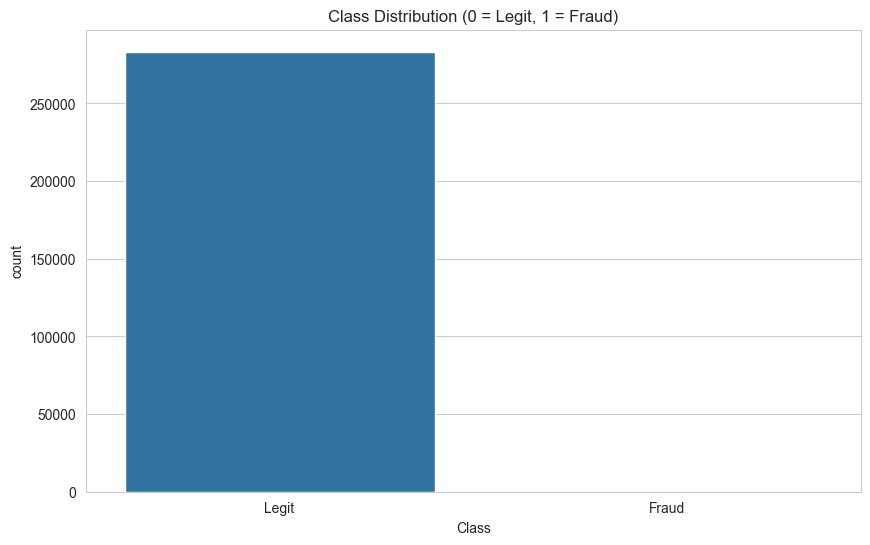

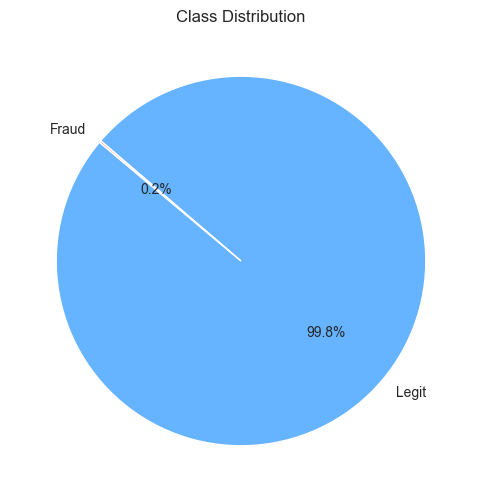

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Class')
plt.xticks([0, 1], ['Legit', 'Fraud'])
plt.title("Class Distribution (0 = Legit, 1 = Fraud)")
plt.show()

classLabels = ['Legit', 'Fraud']
plt.figure(figsize=(6, 6))
plt.pie(df['Class'].value_counts(), labels=classLabels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
plt.title("Class Distribution")
plt.show()


**Observation:** Visualizing features for both classes must account for heavy class imbalance — the majority of transactions are non-fraud (Class = 0), while fraud cases (Class = 1) are very rare. And we will balance the dataset using 'SMOTE' technique.

Such imbalance makes the problem more difficult, because a simple model that predicts only "non-fraud" would already have very high accuracy.
That is why later we will need to focus on other metrics like Precision, Recall, F1-score and ROC-AUC, instead of just accuracy.

### 5.2 Feature Distributions
- Plot distribution of key features (amount, time, etc.)

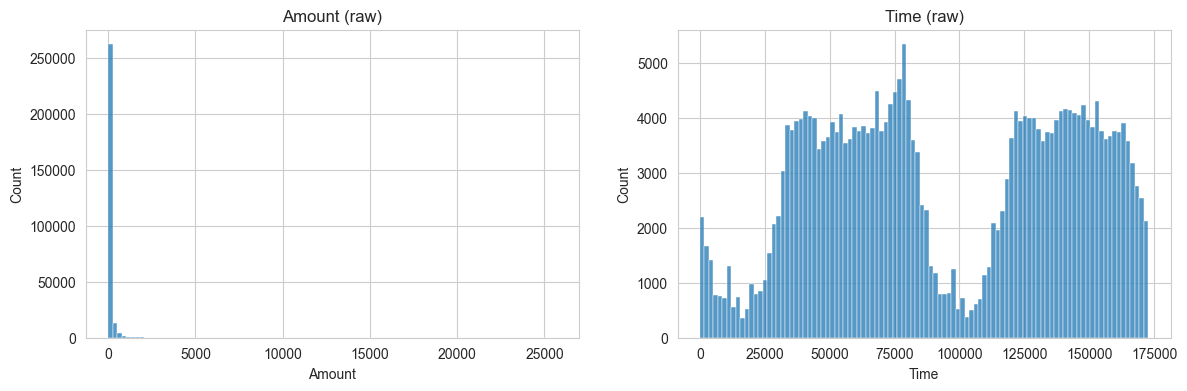

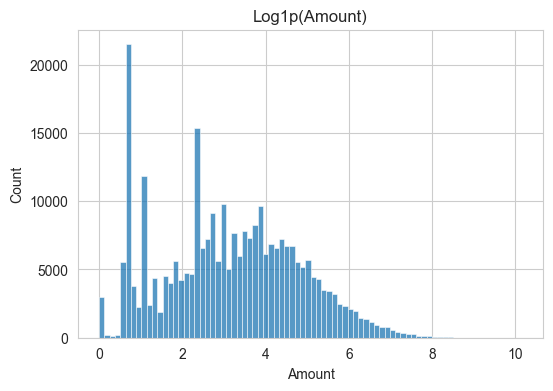

In [9]:
# 5) Amount and Time distributions
fig, axes = plt.subplots(1,2, figsize=(14,4))
sns.histplot(df['Amount'], bins=100, ax=axes[0])
axes[0].set_title('Amount (raw)')
sns.histplot(df['Time'], bins=100, ax=axes[1])
axes[1].set_title('Time (raw)')
plt.show()

# log-scale Amount for better visualization
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(df['Amount']), bins=80)
plt.title("Log1p(Amount)")
plt.show()


**Observation & Decision:**  
- Because `Amount` is heavily skewed, it's advisable to transform/scale it before modeling (RobustScaler or log1p).  
- For `Time`, we can scale it and/or derive `hour_of_day` via `((Time % 86400) // 3600)` to capture cyclical patterns if meaningful.


In [10]:
# Create scaled features

# Robust scale Amount to reduce the effect of outliers
robust_scaler = RobustScaler()
df['scaled_amount'] = robust_scaler.fit_transform(df[['Amount']])

# Standard scale Time
standard_scaler = StandardScaler()
df['scaled_time'] = standard_scaler.fit_transform(df[['Time']])

# Option: drop original columns, but keep a copy of original df if needed
df = df.drop(['Amount','Time'], axis=1)
print("\nData after scaling and dropping original columns:")
df.head()



Data after scaling and dropping original columns:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.774718,-1.996823
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.268530,-1.996823
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.959811,-1.996802
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.411487,-1.996802
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.667362,-1.996781


**Observation:** With scaled features added, next step is to check feature correlations with `Class` and among themselves. Keep in mind `V` features are PCA components — correlations may be non-intuitive but can still signal predictive power.


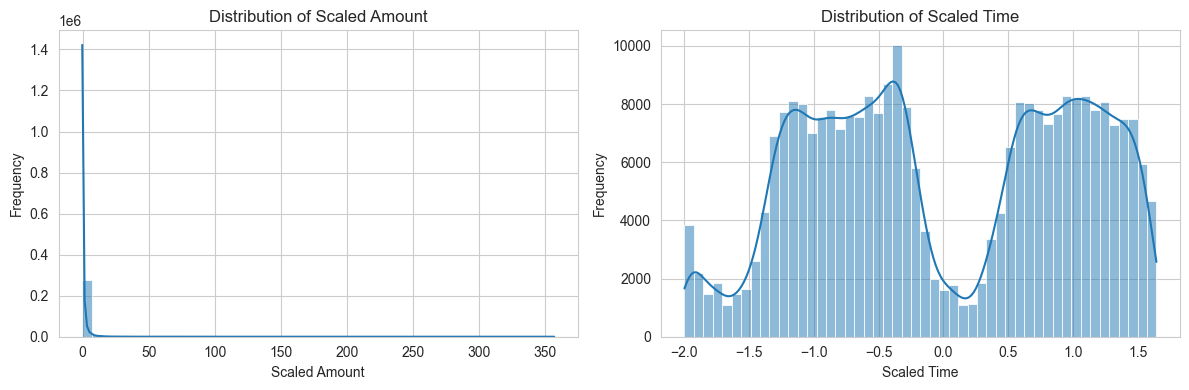

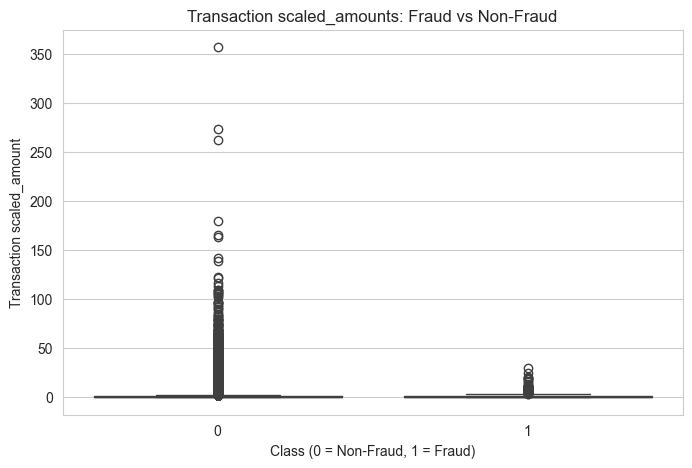

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(df['scaled_amount'], bins=50, ax=ax[0], kde=True)
ax[0].set_title('Distribution of Scaled Amount')
ax[0].set_xlabel('Scaled Amount')
ax[0].set_ylabel('Frequency')

sns.histplot(df['scaled_time'], bins=50, ax=ax[1], kde=True)
ax[1].set_title('Distribution of Scaled Time')
ax[1].set_xlabel('Scaled Time')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# compare fraud vs non-fraud amounts
plt.figure(figsize=(8,5))
sns.boxplot(x='Class', y='scaled_amount', data=df)
plt.title("Transaction scaled_amounts: Fraud vs Non-Fraud")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Transaction scaled_amount")
plt.show()


**Observation:** Most transactions involve small amounts, with only a few large outliers. Transaction frequency varies over time, but fraud cases are rare and distributed throughout the timeline, indicating that fraud can occur at any time. Fraudulent transactions do not consistently have higher amounts than non-fraudulent ones, so neither time nor amount alone is a strong predictor of fraud, but both may provide value when combined with other features.


### 5.3 Correlation Analysis
- Visualize feature correlations

In [13]:
# Correlation data
corr = df.corr()['Class'].abs().sort_values(ascending=False)
display(corr.head(20))

Class    1.000000
V17      0.313498
V14      0.293375
V12      0.250711
V10      0.206971
V16      0.187186
V3       0.182322
V7       0.172347
V11      0.149067
V4       0.129326
V18      0.105340
V1       0.094486
V9       0.094021
V5       0.087812
V2       0.084624
V6       0.043915
V19      0.033631
V8       0.033068
V21      0.026357
V27      0.021892
Name: Class, dtype: float64

**Observation:** The top features returned above are the ones to examine closely. They are candidates for feature importance or feature engineering. However: correlations alone do not guarantee predictive value in multivariate models (check multicollinearity, interactions, and model-based importance).


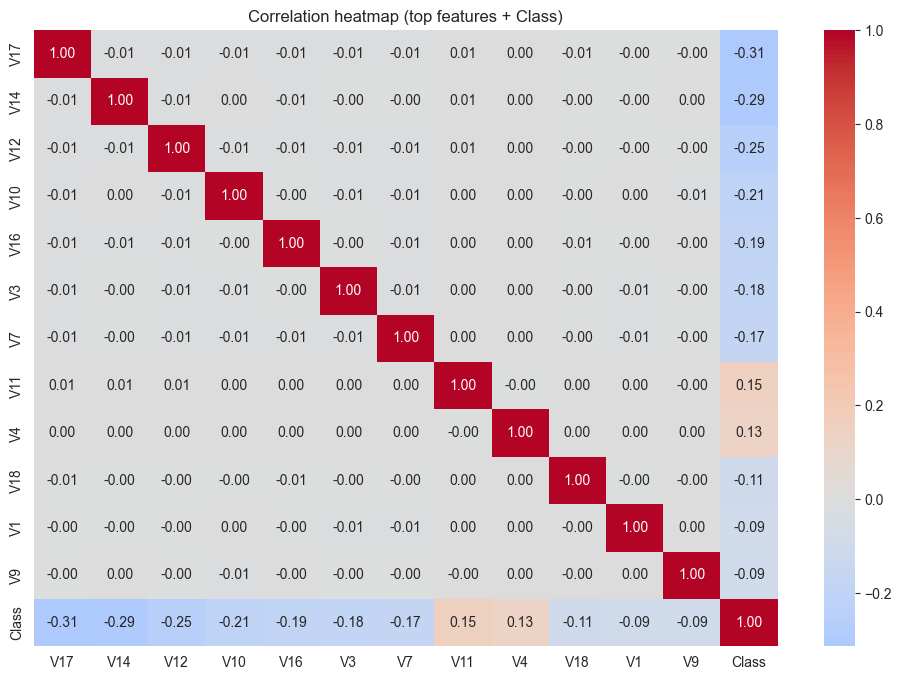

In [14]:
# heatmap for top correlated features
top_correlated_features = corr.index[1:13].tolist()  # skip 'Class' itself
sub = df[top_correlated_features + ['Class']]
plt.figure(figsize=(12,8))
sns.heatmap(sub.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation heatmap (top features + Class)")
plt.show()


**Observation:** Use boxplots/violin plots to compare distributions between classes for selected features. Because of class imbalance, sample the majority class when plotting to avoid plotting hundreds of thousands of points at once.


### 5.4 Outlier Detection
- Boxplot visualization for all features

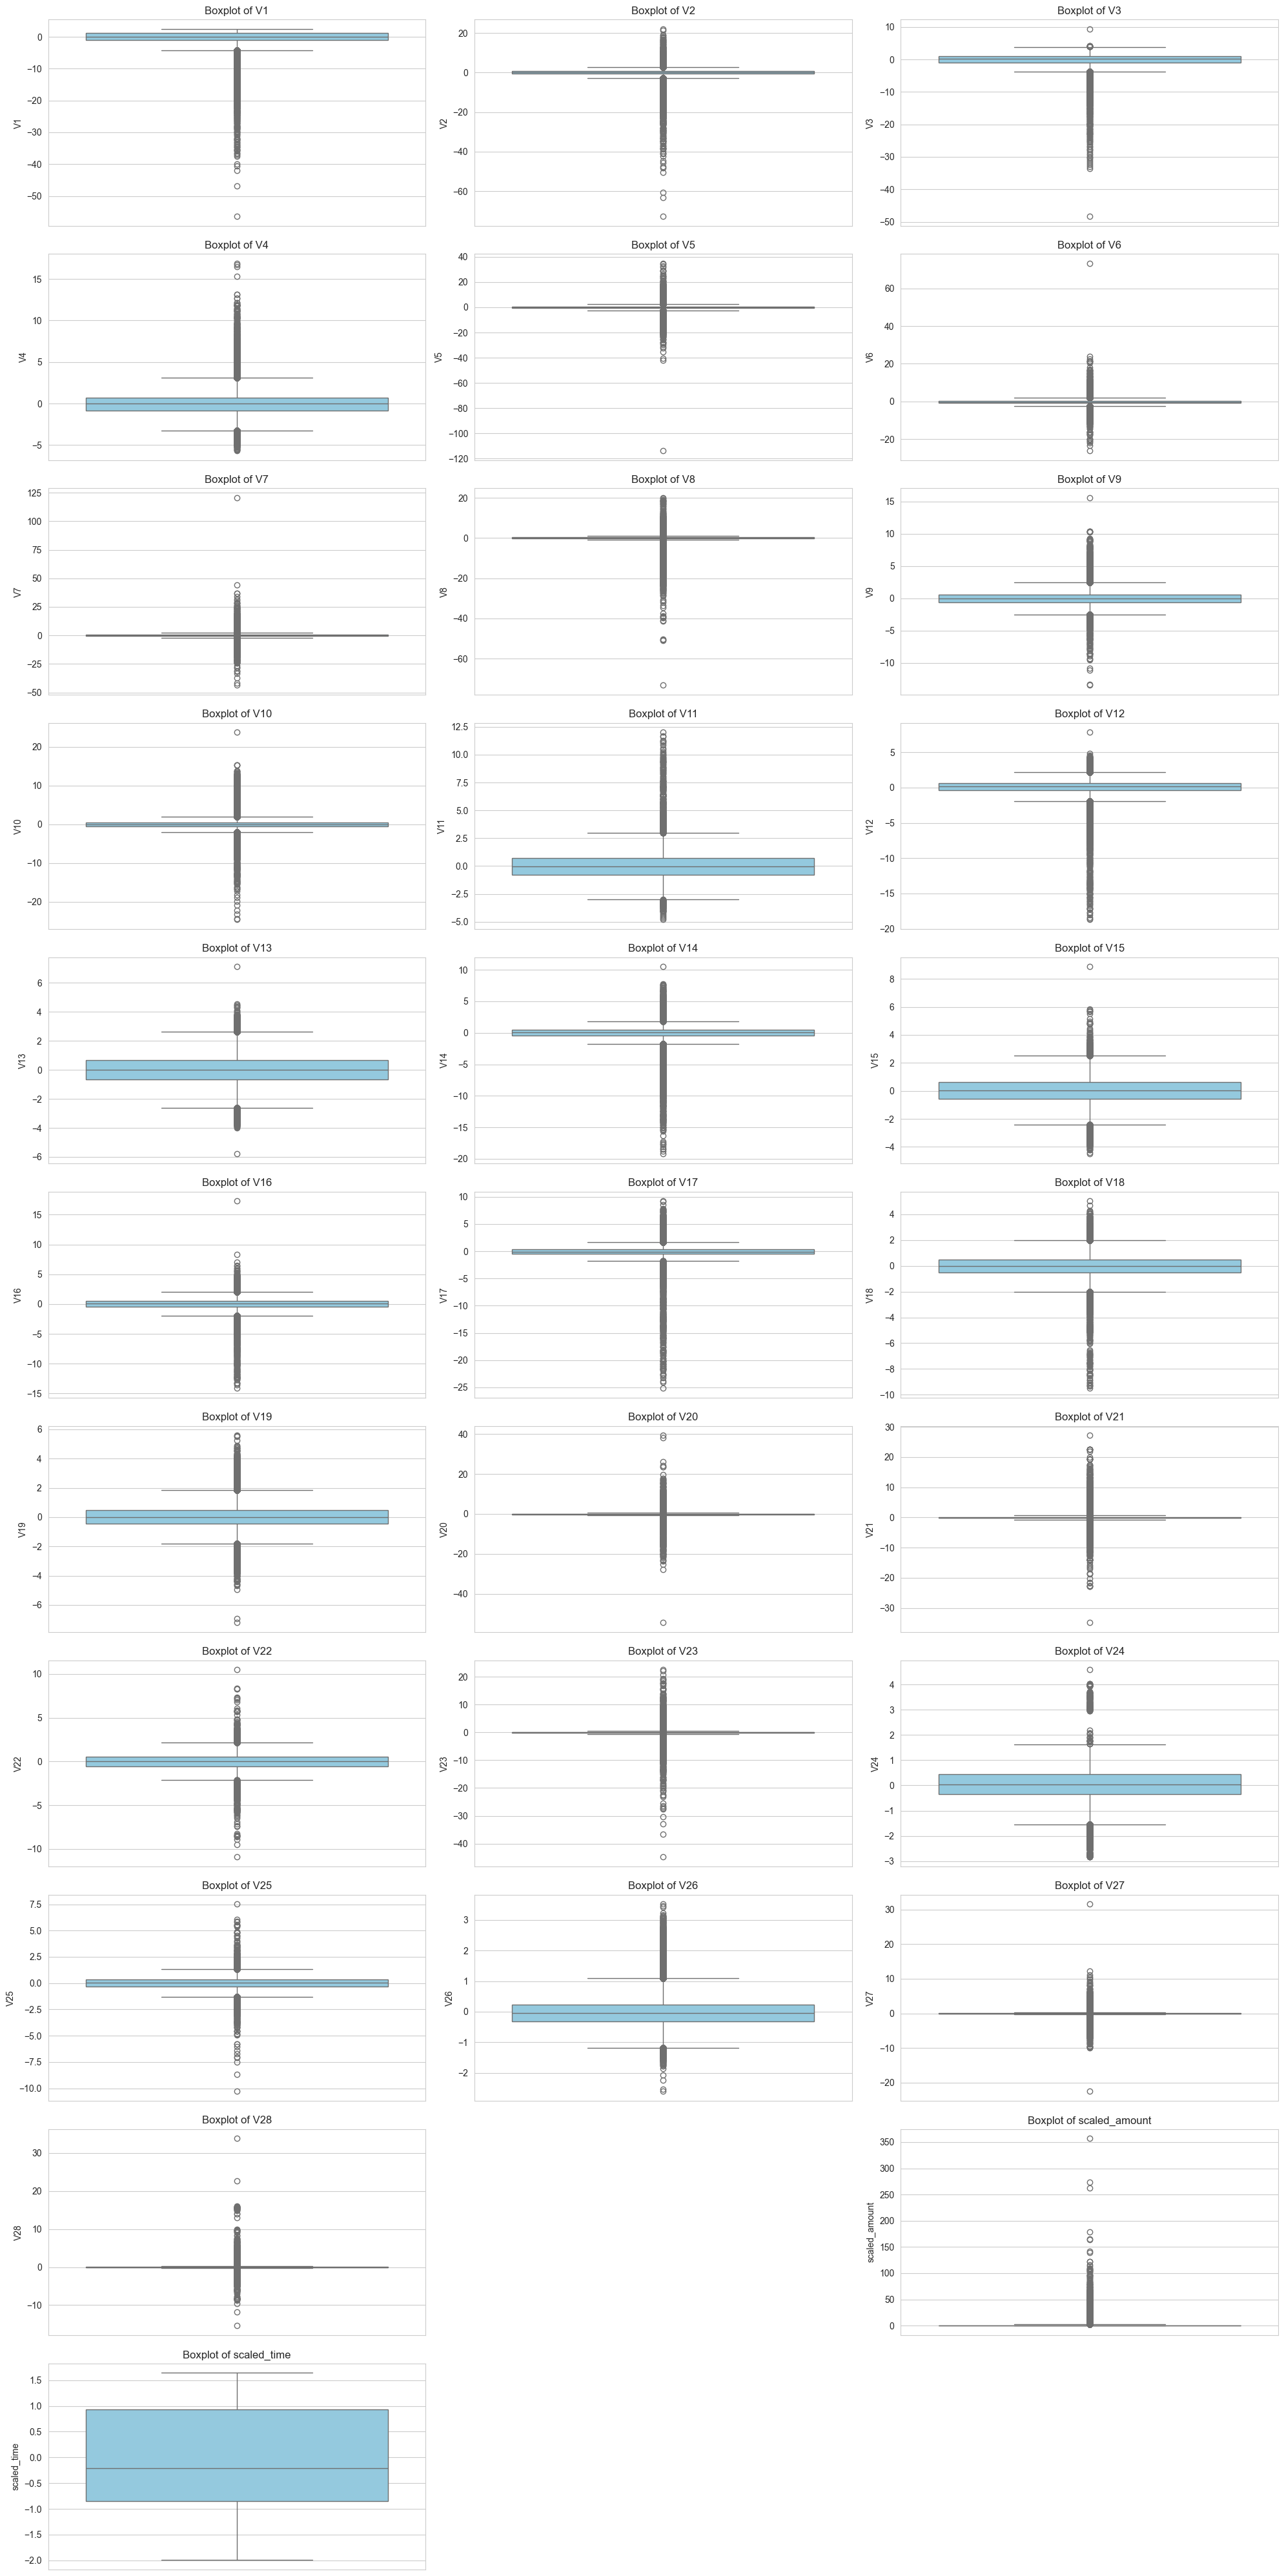

In [15]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 40))
    
for i, col in enumerate(numeric_cols, 1):
    if col != 'Class':
        plt.subplot(len(numeric_cols)//3 + 1, 3, i)
        sns.boxplot(data=df, y=col,  color='skyblue') 
        plt.title(f"Boxplot of {col}") 

plt.tight_layout()
plt.show()

**Observation:** No outliers

## Setp 6: Save Cleaned Data & scalers
- Export cleaned dataset for modeling
- Save scalers to use later

In [16]:

OUT_PATH = "../data/cleaned_creditcard.csv"
df.to_csv(OUT_PATH, index=False)
print("Saved cleaned dataset to:", OUT_PATH)

# Persist scaler for deployment (example uses joblib)
os.makedirs("../models", exist_ok=True)

joblib.dump(robust_scaler, "../models/robust_scaler.joblib")
joblib.dump(standard_scaler, "../models/standard_scaler.joblib")
print("Saved scalers to ../models/")


Saved cleaned dataset to: ../data/cleaned_creditcard.csv


NameError: name 'joblib' is not defined

## EDA Summary & Next Steps

**Key findings:**
- Dataset is highly imbalanced (~0.17% fraud). Accuracy is a bad metric; prefer precision/recall, F1, PR-AUC.
- `Amount` is skewed; RobustScaler transform is used for scaling.
- Several `V` components show moderate correlation with `Class` — candidate features.
- Next steps: build a baseline Logistic Regression with resampling (SMOTE) and evaluate; compare with tree-based models (RandomForest, XGBoost). Persist preprocessing pipeline and trained model for deployment.


